<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Rede_Siamesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
import zipfile as zf
import numpy as np
import shutil
import cv2
import os

size = 96

# Datasets

## Funções

In [2]:
def visualize(dataset):
  """Visualize a few triplets from the supplied batches."""
  for anchor, positive, negative in dataset.take(1):
    def show(ax, image):
        ax.imshow(image, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[0])
        show(axs[i, 1], positive[0])
        show(axs[i, 2], negative[0])

### Mnist

In [3]:
def descompactar_dataset(local):
  shutil.rmtree("Dataset", ignore_errors=True)
  local_destino = "Dataset"
  os.mkdir(local_destino) # Cria a pasta para salvar as imagens
  z = zf.ZipFile((local + ".zip"), 'r')
  z.extractall(local_destino)
  z.close()


def process_diretorio(local_img):
  img = cv2.imread(local_img, 0)
  img = np.array([img]) 
  img = img.reshape(1, 96, 96)
  #img = img/255 # sera feita dentro dos modelos
  return img


def dataset_diretorio(quantidade_imagens = 20000): 
  nb_classes = 10
  local_base = "/content/Dataset/treino/"
  triplets=[np.zeros((quantidade_imagens, 1, 96, 96)) for i in range(3)]

  for i in range(quantidade_imagens):
    if i % 1000 == 0:
      print(str(i) + " imagens foram adicionadas.")

    anchor_class = np.random.randint(0, nb_classes) # Sorteia o indice de uma das classes de 0 a 9
    local_ancora = local_base + str(anchor_class)
    local_positiva = local_ancora 
    lista_imagens = os.listdir(local_ancora)
    nb_sample_available_for_class_AP = len(lista_imagens) # verifica a quantidade de imagens na classe de indice anchor_class
 
    # imagem ancora
    idx_A = np.random.randint(0, nb_sample_available_for_class_AP)
    local_ancora = local_ancora + "/" + lista_imagens[idx_A]

    # imagem positiva
    idx_P = np.random.randint(0, nb_sample_available_for_class_AP)
    local_positiva =  local_positiva + "/" +  lista_imagens[idx_P]

    # Imagem negativa
    negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes # seleciona uma outra classe para ser a negativa
    local_negativa = local_base + str(negative_class)
    lista_imagens = os.listdir(local_negativa)
    nb_sample_available_for_class_N = len(lista_imagens)
    idx_N = np.random.randint(0, nb_sample_available_for_class_N)
    local_negativa = local_negativa + "/" +  lista_imagens[idx_N]

    triplets[0][i,:,:,:] = process_diretorio(local_ancora)
    triplets[1][i,:,:,:] = process_diretorio(local_positiva)
    triplets[2][i,:,:,:] = process_diretorio(local_negativa)
 
  dataset = tf.data.Dataset.zip((
  tf.data.Dataset.from_tensor_slices(triplets[0]), # anchor_dataset
  tf.data.Dataset.from_tensor_slices(triplets[1]), # positive_dataset
  tf.data.Dataset.from_tensor_slices(triplets[2])))# negative_dataset
  return dataset 

## Gerar DataSet

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#descompactar_dataset("/content/drive/MyDrive/Codedepot/DataSets/mnist")

dataset = dataset_diretorio(quantidade_imagens = 15000)
dataset = dataset.shuffle(buffer_size=1024)
#visualize(dataset)

train_ds = dataset.take(round(len(dataset) * 0.8))
val_ds = dataset.skip(round(len(dataset) * 0.8))

print("Total de imagens: " + str(len(dataset)))
print("   Treinamento: " + str(len(train_ds)))
print("   Validação: " + str(len(val_ds)))


train_ds = train_ds.batch(32, drop_remainder=False)
val_ds = val_ds.batch(32, drop_remainder=False)
train_ds = train_ds.prefetch(8)
val_ds = val_ds.prefetch(8)

0 imagens foram adicionadas.
1000 imagens foram adicionadas.
2000 imagens foram adicionadas.
3000 imagens foram adicionadas.
4000 imagens foram adicionadas.
5000 imagens foram adicionadas.
6000 imagens foram adicionadas.
7000 imagens foram adicionadas.
8000 imagens foram adicionadas.
9000 imagens foram adicionadas.
10000 imagens foram adicionadas.
11000 imagens foram adicionadas.
12000 imagens foram adicionadas.
13000 imagens foram adicionadas.
14000 imagens foram adicionadas.
Total de imagens: 15000
   Treinamento: 12000
   Validação: 3000


# Modelo

## Arquitetura NasNetMobile (Funciona)

In [5]:
# Referencia keras: https://github.com/keras-team/keras-applications/blob/06fbeb0f16e1304f239b2296578d1c50b15a983a/keras_applications/nasnet.py#L487
# Referencia 2: https://github.com/johannesu/NASNet-keras/blob/5a0177cdcae2cc330c17960b0adcb458431697be/nasnet.py#L184

def _separable_conv_block(ip, filters,kernel_size=(3, 3),strides=(1, 1)):

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  x = layers.Activation('relu')(ip)
  x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(ip)
  x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)

  return x


def _adjust_block(p, ip, filters):
  # Ajusta o input da saida anterior, para ela ser compativel com o input da saida atual

  # p saida anterior que vai ser ajustada e retornada
  # ip saida atual, para a qual a anterior precisa ser ajsutada. 
  # filters Numero de filtros do ajuste
   
  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
  img_dim = 2 if tf.keras.backend.image_data_format() == 'channels_first' else -2

  ip_shape = tf.keras.backend.int_shape(ip)

  if p is not None: 
    p_shape = tf.keras.backend.int_shape(p)
 

  if p is None:
    p = ip
  elif p_shape[img_dim] != ip_shape[img_dim]: # Verifica se dimensão so shape é diferente. verifica se (None, 90, 90, 96) do p e ip  são 90  
    p = layers.Activation('relu')(p)
    p1 = layers.AveragePooling2D((1, 1),strides=(2, 2),padding='valid')(p)
    p1 = layers.Conv2D(filters // 2, (1, 1),padding='same')(p1)

    p2 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(p)
    p2 = layers.Cropping2D(cropping=((1, 0), (1, 0)))(p2)
    p2 = layers.AveragePooling2D((1, 1),strides=(2, 2),padding='valid')(p2)
    p2 = layers.Conv2D(filters // 2, (1, 1),padding='same')(p2)

    p = layers.concatenate([p1, p2], axis=channel_dim)
    p = layers.BatchNormalization()(p)

  elif p_shape[channel_dim] != filters:
    p = layers.Activation('relu')(p)
    p = layers.Conv2D(filters,(1, 1),strides=(1, 1),padding='same')(p)
    p = layers.BatchNormalization()(p)
  return p


def  _reduction_a_cell(ip, p, filters):
  # Com base na figura 4 do artigo https://arxiv.org/pdf/1707.07012.pdf
  # A sequencia dos blocos foi feita da esquerda para a direita.

  # ip é a saida atual (no artiogo é o Hi)
  # p é a saida anterior (no artigo é o Hi-1)

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  p = _adjust_block(p, ip, filters) # Ajusta a saida anterior p para o input da saida atual ip

  h = layers.Activation("relu")(ip) 
  h = layers.Conv2D(filters = filters, kernel_size = 1, strides = (1, 1), padding="same")(h)
  h = layers.BatchNormalization()(h) 


  # add = sep 7x7, sep 5x5 
  X1_1 = _separable_conv_block(p, filters, kernel_size=(7, 7), strides=(2, 2))
  X1_2 = _separable_conv_block(h, filters, kernel_size=(5, 5), strides=(2, 2))
  add_1 = layers.Add()([X1_1, X1_2])

  # add = max 3x3 , sep 7x7
  X2_1 = layers.MaxPooling2D(3, strides=2, padding='same')(h) 
  X2_2 = _separable_conv_block(p, filters, kernel_size=(7, 7), strides=(2, 2))
  add_2 = layers.Add()([X2_1, X2_2])

  # add = avg 3x3, sep 5x5
  X3_1 = layers.AveragePooling2D(3, strides=2, padding='same')(h)
  X3_2 = _separable_conv_block(p, filters, kernel_size=(5, 5), strides=(2, 2))
  add_3 = layers.Add()([X3_1, X3_2])

  # add = max 3x3, sep 3x3
  X4_1 = layers.MaxPooling2D(3, strides=2, padding='same')(h) 
  X4_2 = _separable_conv_block(add_1, filters, kernel_size=(3, 3))
  add_4 = layers.Add()([X4_1, X4_2])

  # add = avg 3x3, identity
  X5_1 = layers.AveragePooling2D(3, strides=1, padding='same')(add_1)
  add_5 = layers.Add()([X5_1, add_2])
  # Concat
  return layers.Concatenate(axis=channel_dim)([add_2, add_3, add_4, add_5]), ip



def  _NormalCell(ip, p, filters):
  # Com base na figura 4 do artigo https://arxiv.org/pdf/1707.07012.pdf
  # A sequencia dos blocos foi feita da esquerda para a direita.
  # ip é a saida atual (no artiogo é o Hi)
  # p é a saida anterior (no artigo é o Hi-1)

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  p = _adjust_block(p, ip, filters) # Ajusta a saida anterior p para o input da saida atual ip

  h = layers.Activation("relu")(ip) 
  h = layers.Conv2D(filters = filters, kernel_size = 1, strides = (1, 1), padding="same")(h)
  h = layers.BatchNormalization()(h) 

  # add = sep 3x3, identity
  X1_1 = _separable_conv_block(h, filters)
  add_1 = layers.Add()([X1_1, h])

  # add = sep 3x3, sep 5x5
  X2_1 = _separable_conv_block(p, filters) # o kernel_size padrão é 3x3, por isso não precisa especifica-lo
  X2_2 = _separable_conv_block(h, filters, kernel_size=5)
  add_2 = layers.Add()([X2_1, X2_2])

  # add = avg 3x3, identity
  X3_1 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(h)
  add_3 = layers.Add()([X3_1, p])

  # add = avg 3x3, avg 3x3
  X4_1 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(p)
  X4_2 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(p)
  add_4 = layers.Add()([X4_1, X4_2])

  # add = sep 3x3, sep 5x5
  X5_1 = _separable_conv_block(p, filters) 
  X5_2 = _separable_conv_block(p, filters, kernel_size=5)
  add_5 = layers.Add()([X5_1, X5_2])

  # concat
  return layers.Concatenate(axis=channel_dim)([p, add_1, add_2, add_3, add_4, add_5]), ip 

In [6]:
def NASNetMobile(input_shape):
  num_blocks = 4
  block_filters = 32 
  skip_reduction = False
  penultimate_filters  = 1056
  filter_multiplier = 2   # filter_multiplier: Controls the width of the network.
                          #   - If `filter_multiplier` < 1.0, proportionally decreases the number of filters in each layer.
                          #   - If `filter_multiplier` > 1.0, proportionally increases the number of filters in each layer.
                          #   - If `filter_multiplier` = 1, default number of filters from the paper are used at each layer.
  


  inputs = keras.Input(shape = input_shape)
  #x = data_augmentation(inputs)  # Apply random data augmentation

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(inputs)

  # 3x3 conv stride 2
  x = layers.Conv2D(filters=block_filters, kernel_size=3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)


  # Reducion Cell
  p = None # é a saida anterior, e no inicio ela não existe por isso é None
  filters = penultimate_filters // 24 # Faz a divisão e retorna como inteiro
  x, p = _reduction_a_cell(x, p, filters // (filter_multiplier ** 2))
  x, p = _reduction_a_cell(x, p, filters // filter_multiplier)

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters)

  # Reducion Cell
  x, p0 = _reduction_a_cell(x, p, filters * filter_multiplier)
  p = p0 if not skip_reduction else p

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters * filter_multiplier)

  # Reducion Cell
  x, p0 = _reduction_a_cell(x, p, filters * filter_multiplier ** 2)
  p = p0 if not skip_reduction else p

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters * filter_multiplier ** 2)

  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)

  # No lugar da rede densa
  x = layers.Flatten()(x)
  x = layers.Dense(128, name='dense_layer')(x)
    
  # L2 normalization
  outputs = layers.Lambda(lambda  x: tf.math.l2_normalize(x,axis=1))(x)
  
  return keras.Model(inputs, outputs, name="NasNetMobile")

## Arquitetura NIN (Funciona)

In [5]:
# https://paperswithcode.com/paper/network-in-network
# https://github.com/minoring/nin-tf2/blob/master/model.py
def define_nin(input_shape):
  """Define Network in Network model
  Returns:
    tf.keras.Model of NIN
  """
  input_tensor = keras.Input(shape=input_shape)
  x = layers.Conv2D(192, 5, activation='relu')(input_tensor)
  x = layers.Conv2D(160, 1, activation='relu')(x)
  x = layers.Conv2D(96, 1, activation='relu')(x)
  x = layers.MaxPool2D(2, strides=2, padding='same')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(192, 5, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.MaxPool2D(2, strides=2, padding='same')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(192, 3, activation='relu')(x)
  x = layers.Conv2D(192, 1, activation='relu')(x)
  x = layers.Conv2D(10, 1, activation='relu')(x)
  X = layers.GlobalAveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, name='dense_layer')(x)
    
  # L2 normalization
  output_tensor = layers.Lambda(lambda  x: tf.math.l2_normalize(x,axis=1))(x)

  return tf.keras.Model(input_tensor, output_tensor, name = "Arquitetura_NIN")

## Arquitetura Inception (Funciona)

In [5]:
#### PART OF THIS CODE IS USING CODE FROM VICTOR SY WANG: https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/utils.py ####
#### THIS FILE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/fr_utils.py

import tensorflow as tf
import numpy as np
import os
import cv2
from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
import matplotlib.pyplot as plt


_FLOATX = 'float32'

def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict
    
def img_to_encoding(image_path, model):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


In [6]:
#### THIS CODE IS FROM https://github.com/shahariarrabby/deeplearning.ai/blob/master/COURSE%204%20Convolutional%20Neural%20Networks/Week%2004/Face%20Recognition/inception_blocks_v2.py

import tensorflow as tf
import numpy as np
import os
from numpy import genfromtxt
from keras import backend as K
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input #, concatenate
from keras.models import Model

#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
#import fr_utils
from keras.layers.core import Lambda, Flatten, Dense

def inception_block_1a(X):
    """
    Implementation of an inception block
    """
    
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name ='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name = 'inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    
    X_5x5 = Conv2D(16, (1, 1), data_format='channels_first', name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32, (5, 5), data_format='channels_first', name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)
   
    # CONCAT
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1, name="concat_inception_block_1a")

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_1c(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_2a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool, X_1x1], axis=1)
    
    return inception

def inception_block_2b(X):
    #inception4e
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    #X_5x5 = fr_utils.conv2d_bn(X,
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    #inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)
    inception = tf.concat([X_3x3, X_5x5, X_pool], axis=1)
    

    return inception

def inception_block_3a(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    

    return inception

def inception_block_3b(X):
    #X_3x3 = fr_utils.conv2d_bn(X,
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    #X_pool = fr_utils.conv2d_bn(X_pool,
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    #X_1x1 = fr_utils.conv2d_bn(X,
    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    
    #inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)
    inception = tf.concat([X_3x3, X_pool, X_1x1], axis=1)
    
    return inception

def model(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
  
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='model')
        
    return model

## Contrução Rede Siamesa


In [7]:
# https://keras.io/examples/vision/siamese_network/
# https://keras.io/examples/vision/siamese_contrastive/
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
tf.keras.backend.set_image_data_format('channels_first')

input_shape = (1, 96,96)
#input_shape = (96,96, 1)


class DistanceLayer(keras.layers.Layer):
  """
  This layer is responsible for computing the distance between the anchor
  embedding and the positive embedding, and the anchor embedding and the
  negative embedding.
  """

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)



#embedding_model = model(input_shape = input_shape) # Rede Inception
#embedding_model = define_nin(input_shape = input_shape) # Rede NIN
embedding_model = NASNetMobile(input_shape = input_shape) # Rede NasNetMobile

embedding_model.summary()

def Siamese_Network():
  anchor_input = keras.layers.Input(name="anchor", shape= input_shape)
  positive_input = keras.layers.Input(name="positive", shape=input_shape)
  negative_input = keras.layers.Input(name="negative", shape=input_shape)

  distances = DistanceLayer()(
      embedding_model(anchor_input),
      embedding_model(positive_input),
      embedding_model(negative_input),
    )

  return keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name='Siamese_Network')

Model: "NasNetMobile"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 96, 96)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 1, 96, 96)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 48, 48)   320         ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 48, 48)  192         ['conv2d[0][0]']                 
 alization)                                                                            

In [8]:
class SiameseModel(keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.3):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Treinamento

In [9]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor="val_loss", restore_best_weights=True),
  ]

In [10]:
siamese_model = SiameseModel(Siamese_Network())
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001), weighted_metrics=["loss"])

In [ ]:
!nvidia-smi
historico = siamese_model.fit(train_ds, epochs=20, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model_nasnetmobile.h5")

Fri Feb 17 19:55:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    29W /  70W |   8518MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# dfdfgffffd

In [11]:
!nvidia-smi
historico = siamese_model.fit(train_ds, epochs=20, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model_inception.h5")

Fri Feb 17 19:37:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    27W /  70W |   8518MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# f

In [10]:
!nvidia-smi
historico = siamese_model.fit(train_ds, epochs=20, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model_nin.h5")

Epoch 1/20
375/375 [==============================] - 116s 284ms/step - loss: 0.0406 - val_loss: 0.0157
Epoch 2/20
375/375 [==============================] - 102s 272ms/step - loss: 0.0141 - val_loss: 0.0118
Epoch 3/20
375/375 [==============================] - 102s 273ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 4/20
375/375 [==============================] - 102s 273ms/step - loss: 0.0060 - val_loss: 0.0085
Epoch 5/20
375/375 [==============================] - 102s 272ms/step - loss: 0.0032 - val_loss: 0.0093
Epoch 6/20
375/375 [==============================] - 102s 271ms/step - loss: 0.0028 - val_loss: 0.0080
Epoch 7/20
375/375 [==============================] - 101s 270ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 8/20
375/375 [==============================] - 101s 270ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 9/20
375/375 [==============================] - 101s 270ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 10/20
375/375 [==============================] - 101s 270m

In [ ]:
# sdfsdfffdddd

In [ ]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,2,2)
  plt.title(nome + ": Variação do Loss")
  plt.xlabel("Epocas")
  plt.ylabel("Diferença")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()


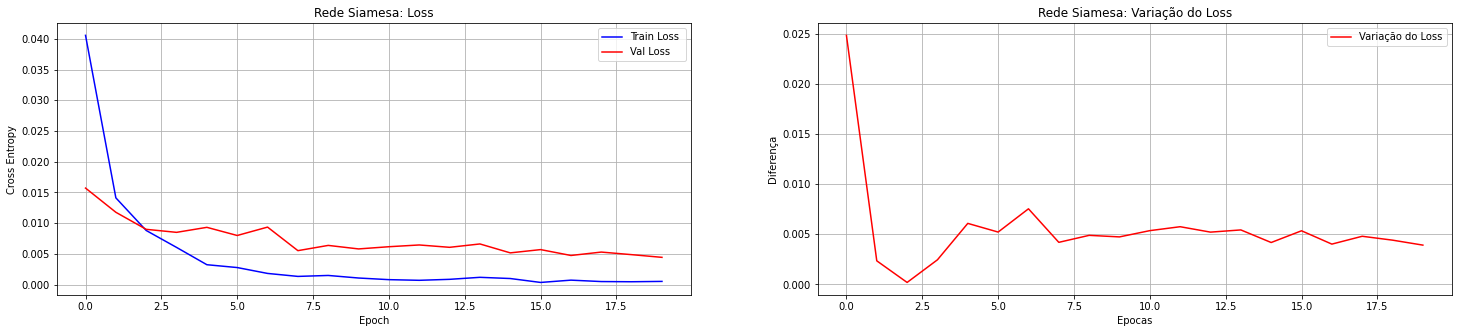

In [14]:
grafico(historico, "Rede Siamesa")

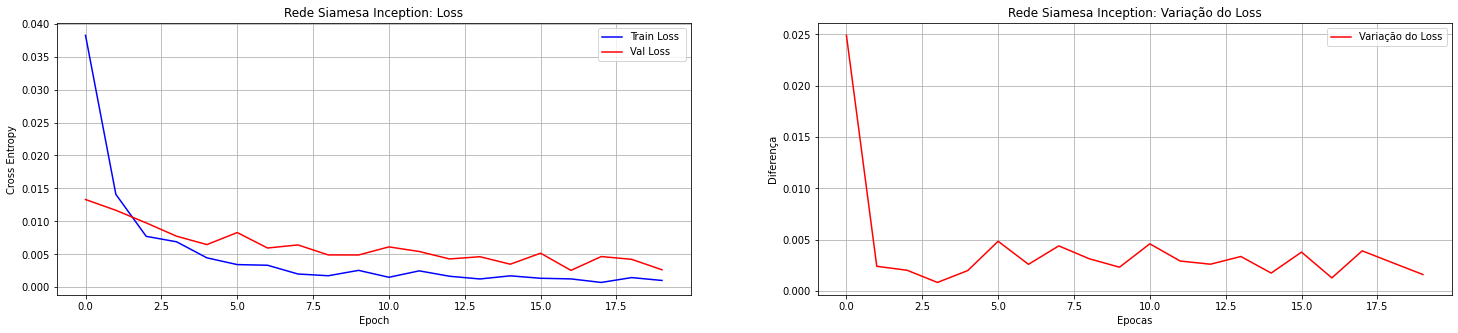

In [15]:
grafico(historico, "Rede Siamesa Inception")

In [ ]:
grafico(historico, "Rede Siamesa NasNetMobile")

# Teste

## Funções

In [16]:
def visualize(x_test_origin):
    """Visualize a few triplets from the supplied batches."""
    print("Total de imagens: {0}  Resolução: {1}x{2}".format(x_test_origin.shape[0], x_test_origin.shape[1], x_test_origin.shape[2]))
    def show(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 1], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 2], x_test_origin[np.random.randint(0, 1000)])

In [17]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def array_to_imagem(image, novo_nome):
  novo_nome = "/content/imagens/" + novo_nome + ".jpg"
  cv2.imwrite(novo_nome, image)

def salvar_ancoras(x_test_origin, y_test_origin):
  os.mkdir("imagens")
  

  indice = 0
  i = 0
  while indice < 10:
    if y_test_origin[i] == indice:
      array_to_imagem(x_test_origin[i], nome[indice])
      indice += 1
    i+= 1

In [18]:
def ler_imagem(local):
  return cv2.imread(local, 0)

In [19]:
def prepare_database(model):
  database = {}
  local = "/content/imagens"
  for imagem in os.listdir(local):
    local_imagem = os.path.join(local, imagem)
    img = ler_imagem(local_imagem)
    identity = os.path.splitext(os.path.basename(local_imagem))[0]
    database[identity] = img_to_encoding(img, model)
  
  return database

In [20]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [34]:
def img_to_encoding(img, model):
  #img = np.resize(img,(size,size))
  img = np.array([img]) 
  img = img.reshape(img.shape[0], 1, size, size)

  embedding = model.predict(img, verbose=0)
  
  return embedding

In [22]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

Total de imagens: 10000  Resolução: 28x28


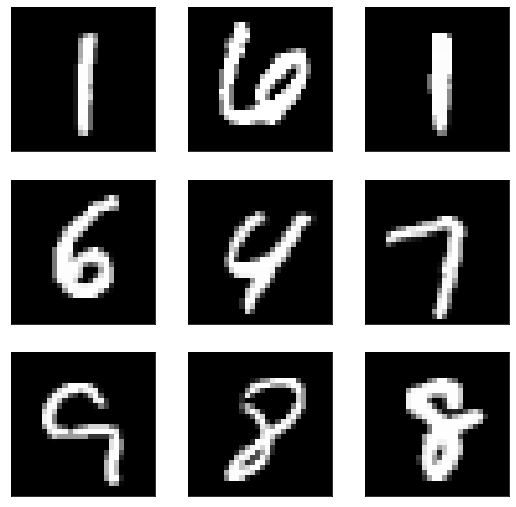

In [24]:
# Permite visualizar algumas imagens do conjunto de teste
visualize(x_test_origin)

In [25]:
# salvar uma imagem de cada classe para ser a ancora
salvar_ancoras(x_test_origin, y_test_origin)

Para classificar um imagem como pertencente a uma das classe, o processo é dividido em 4 fasses: \

1 - uma imagem representando cada classe é codificada. \

2 - a imagem que sera classifica é codificada. \

3 - verifica a distancia da imagem codificada na fasse 2 com cada uma das imagens codificadas na fasse 1. \

4 - a imagem sera classificada de acordo com a menor distancia encontrada na fasse 3.


In [ ]:
embedding_model = tf.keras.models.load_model("/content/embedding_model.h5")

In [33]:
database = prepare_database(embedding_model)
saida = []

for i in range(100): # o maximo é 10000
  classe = recognise_class(x_test_origin[i], database, embedding_model)
  print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[i], classe, i))
  saida.append([y_test_origin[i], classe])

metricas(saida) 

id 0:: Classe Real: 7 >> Classe Prevista: quatro
id 1:: Classe Real: 2 >> Classe Prevista: oito
id 2:: Classe Real: 1 >> Classe Prevista: um
id 3:: Classe Real: 0 >> Classe Prevista: zero
id 4:: Classe Real: 4 >> Classe Prevista: quatro
id 5:: Classe Real: 1 >> Classe Prevista: um
id 6:: Classe Real: 4 >> Classe Prevista: quatro
id 7:: Classe Real: 9 >> Classe Prevista: quatro
id 8:: Classe Real: 5 >> Classe Prevista: seis
id 9:: Classe Real: 9 >> Classe Prevista: quatro
id 10:: Classe Real: 0 >> Classe Prevista: quatro
id 11:: Classe Real: 6 >> Classe Prevista: seis
id 12:: Classe Real: 9 >> Classe Prevista: quatro
id 13:: Classe Real: 0 >> Classe Prevista: quatro
id 14:: Classe Real: 1 >> Classe Prevista: oito
id 15:: Classe Real: 5 >> Classe Prevista: can't recognise.
id 16:: Classe Real: 9 >> Classe Prevista: quatro
id 17:: Classe Real: 7 >> Classe Prevista: zero
id 18:: Classe Real: 3 >> Classe Prevista: oito
id 19:: Classe Real: 4 >> Classe Prevista: quatro
id 20:: Classe Real: 9

In [ ]:
imagens = cv2.imread("/content/temp.jpg", 0)

database = prepare_database(embedding_model)

classe = recognise_class(imagens, database, embedding_model)
print(classe)

In [ ]:
# verifica as imagem que deram errado
cv2.imwrite("teste.jpg",x_test_origin[7])